In [19]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase

In [20]:
from codebase import volume_pipeline

In [21]:
res_shp = codebase.load_data.load_GRanD()

In [22]:
res_ref_M = codebase.load_data.load_formatted_usbr_data('powell',monthly=True)
# res_ref_M = res_ref.resample('M',label='left',closed='left').mean()
# res_ref_M.index = res_ref_M.index + pd.Timedelta('1D') # resampling makes the index one day too early, corrects to first of the month
res_ref_elev = res_ref_M['Lake/Reservoir Elevation [ft]']
res_ref_M.columns

Index(['Lake/Reservoir Area [acres]', 'Lake/Reservoir Bank Storage [af]',
       'Lake/Reservoir Change In Storage [af]',
       'Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Evaporation [af]',
       'Lake/Reservoir Inflow - Unregulated [cfs]',
       'Lake/Reservoir Inflow Volume - Unregulated [af]',
       'Lake/Reservoir Inflow [af]', 'Lake/Reservoir Inflow [cfs]',
       'Lake/Reservoir Release - Bypass [af]',
       'Lake/Reservoir Release - Bypass [cfs]',
       'Lake/Reservoir Release - Powerplant [af]',
       'Lake/Reservoir Release - Powerplant [cfs]',
       'Lake/Reservoir Release - Spillway [cfs]',
       'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]'],
      dtype='object', name='Variable')

In [23]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('glen canyon',res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

# Elevation comparison

## Elevation within a month compared to USBR

In [24]:
res_DEM = volume_pipeline.grab_DEM_of_conditional_area(dem_DA,fw_DA)

In [25]:
dem_1m = res_DEM.isel(time=8)
dem_1m_time = dem_1m['time'].values
res_elev_1m_ft = res_ref_M.loc[dem_1m_time,'Lake/Reservoir Elevation [ft]']
res_elev_1m = codebase.utils.convert_from_ft_to_m(res_elev_1m_ft)

1088 meters


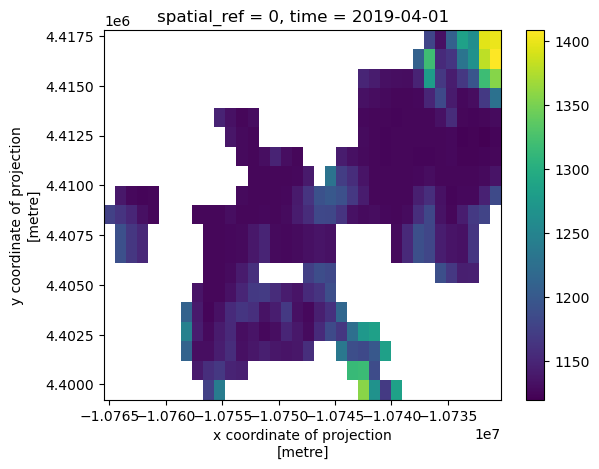

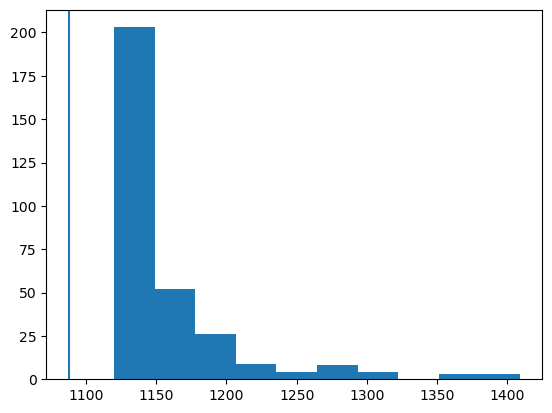

In [26]:
print(f'{res_elev_1m:.0f} meters')
_ = codebase.plotting_functions.map_data_array_values(dem_1m)#, hist_kwargs={'range':(100,200)})

plt.axvline(x=res_elev_1m)

## Elevation with existing methods

In [27]:
from scipy.stats import norm
norm_fits = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA, fw_DA, 1, norm)
norm_elev_m = [val[0] for val in norm_fits]
norm_elev_series_m = pd.Series(index=fw_DA['time'], data = norm_elev_m)

In [28]:
ref_elev_m = codebase.utils.convert_from_ft_to_m(res_ref_elev)

In [29]:
norm_elev_match ,ref_elev_match = codebase.time_series_calcs.intersecting_timeframes(norm_elev_series_m,ref_elev_m)

ValueError: x and y must be the same size

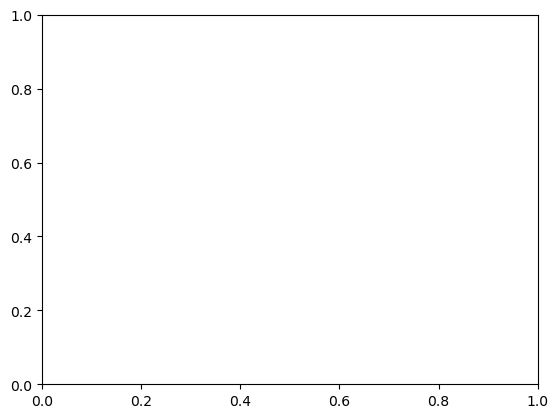

In [30]:
# Comparison of ref and calculated heights
mn = ref_elev_match.index[0].timestamp()*1e9
mx = ref_elev_match.index[-1].timestamp()*1e9

plt.scatter(ref_elev_match, norm_elev_match ,c=ref_elev_match.index,vmin=mn, vmax=mx)
cbar = plt.colorbar()
cbar.set_ticks([mn,mx])
cbar.set_ticklabels([ref_elev_match.index[0],ref_elev_match.index[-1]])
plt.xlabel('USBR elevation (m)')
plt.ylabel('Calculated elevation from DEM distribution (m?)')
plt.title('Monthly elevation of Lake Havasu');

## Change in elevation (aka height) comparison

In [ ]:
# Grab height from volume pipeline
height_array = volume_pipeline.calculate_height_time_series_from_start_and_change_in_DEM(
        dem_DA, fw_DA, fw_diff_DA, change_cond_DA) * change_cond_DA.values
height_series = pd.Series(index = fw_diff_DA['time'], data = height_array)

height_series

In [ ]:
res_ref_elev

In [ ]:
ref_height_m = res_ref_elev.diff()[1:]/3.28

In [ ]:
height_series_match ,res_ref_elev_match = codebase.time_series_calcs.intersecting_timeframes(height_series,ref_height_m)

In [ ]:
mn = res_ref_elev_match.index[0].timestamp()*1e9
mx = res_ref_elev_match.index[-1].timestamp()*1e9

In [ ]:
# Comparison of ref and calculated heights
plt.scatter(height_series_match ,res_ref_elev_match,c=res_ref_elev_match.index,vmin=mn, vmax=mx)
cbar = plt.colorbar()
cbar.set_ticks([mn,mx])
cbar.set_ticklabels([res_ref_elev_match.index[0],res_ref_elev_match.index[-1]])
plt.xlabel('Calculated elevation from DEM distribution (m?)')
plt.ylabel('USBR elevation (m)')
plt.title('Monthly change in elevation of Lake Mead');

Conclusion: DEM extraction is currently not a good match to reference elevation series.

In [ ]:
res_ref_M.plot(y='Lake/Reservoir Release - Total [cfs]', label='USBR')
test_vol.to_dataframe()['Watermask'].plot(label='Experimental',secondary_y= True)

In [ ]:
fw_diff_DA.isel(time=1).plot(cmap='RdBu')